In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines,rpy2

cs224 
last updated: 2020-04-10 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
lifelines 0.24.2
rpy2 3.2.6


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Estimates of the severity of coronavirus disease 2019: a model-based analysis](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext)
    * duration from onset of symptoms to death to be 17·8 days (95% credible interval [CrI] 16·9–19·2)
    * to hospital discharge to be 24·7 days (22·9–28·1).
* [Estimating SARS-COV-2 infections](https://observablehq.com/@danyx/estimating-sars-cov-2-infections)
    * it takes on average 23 days from infection to death.
    * ~5 days from infection to symptoms and ~18 days from symptoms to death so we arrive at a default value of 23 days from infection to death
* [Characteristics of COVID-19 patients dying in Italy Report based on available data on March 20th, 2020](https://www.epicentro.iss.it/coronavirus/bollettino/Report-COVID-2019_20_marzo_eng.pdf)
    * Median number of days between onset of symptoms to death: 8
    * Median number of days between onset of symptoms to hospitalization: 4
* [Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext)
    * Time from illness onset to hospital admission, days	11·0 (8·0–14·0)
* [Coronavirus: how quickly do COVID-19 symptoms develop and how long do they last?](https://patient.info/news-and-features/coronavirus-how-quickly-do-covid-19-symptoms-develop-and-how-long-do-they-last)
    * ~5 days from infection to symptoms


* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

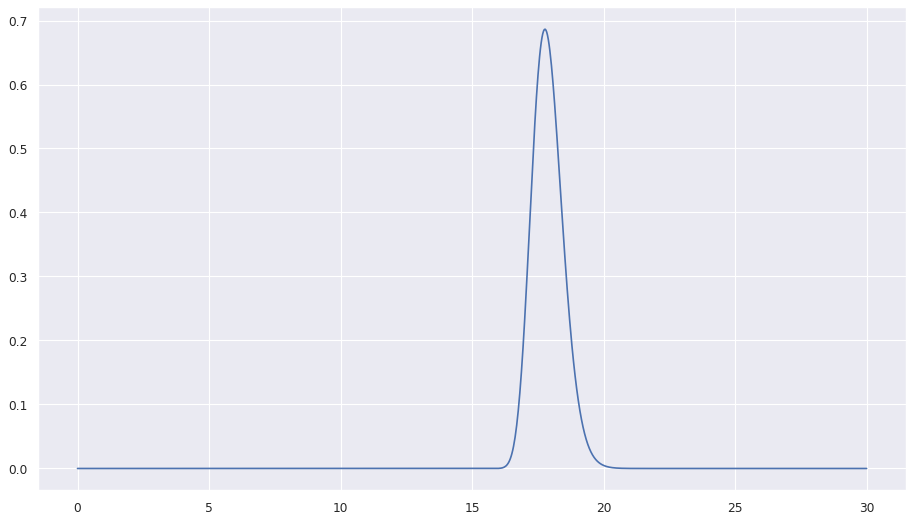

In [5]:
x = np.linspace(0.0,30.0,1000)
y = covid19.gamma_dist.pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

(4.05, 3.91, 4.18, 3.93, 6.244924187841993)


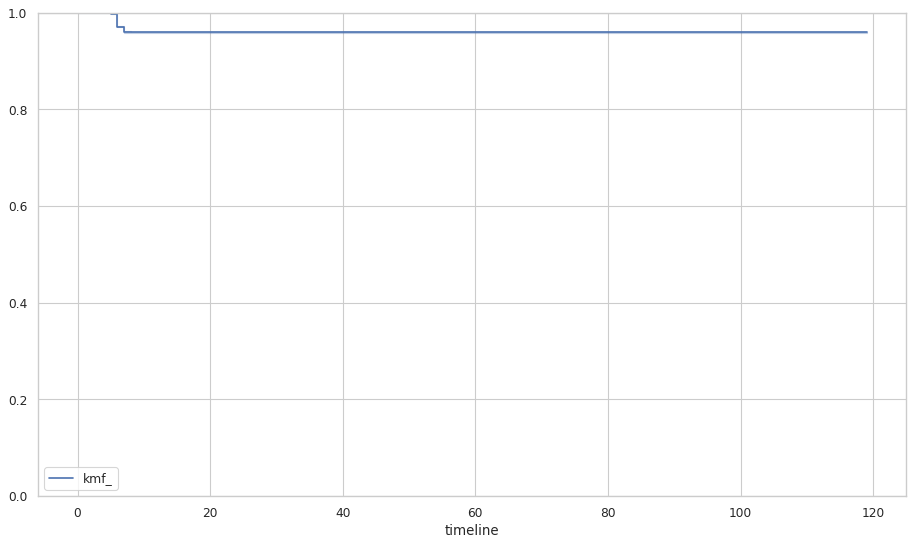

In [6]:
country_name, first_date, init_add = 'China', None, 0
# cfr_estimate, timeshift = covid19.calculate_delay_between_new_cases_and_death(country_name, first_date=first_date, init_add=init_add)
# print(cfr_estimate, timeshift)
# loc = max(timeshift - (gamma_mean - gamma_loc), 0.0)
china_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
china_mortality_analysis.fit()
print(china_mortality_analysis.death_rate())
china_mortality_analysis.plot()

In [7]:
china_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,82602,77207,3333,59,261,3
2020-04-06,82665,77310,3335,63,103,2
2020-04-07,82718,77410,3335,53,100,0
2020-04-08,82809,77567,3337,91,157,2
2020-04-09,82883,77679,3339,74,112,2


In [8]:
# china_mortality_analysis.df_lifelines_individual.observed_death.sum()

In [9]:
# china_mortality_analysis.df.head()

In [10]:
# china_mortality_analysis.df.tail()

In [19]:
# china_mortality_analysis.fit()

In [12]:
# china_mortality_analysis.wbf.print_summary()

# expected_life_time = china_mortality_analysis.wbf.lambda_ * scipy.special.gamma(1 + 1 / china_mortality_analysis.wbf.rho_)
# expected_life_time/365

In [20]:
# china_mortality_analysis.death_rate()

In [21]:
# china_mortality_analysis.plot()

(3.27, 3.14, 3.4, 3.23, 9.370633408721732)


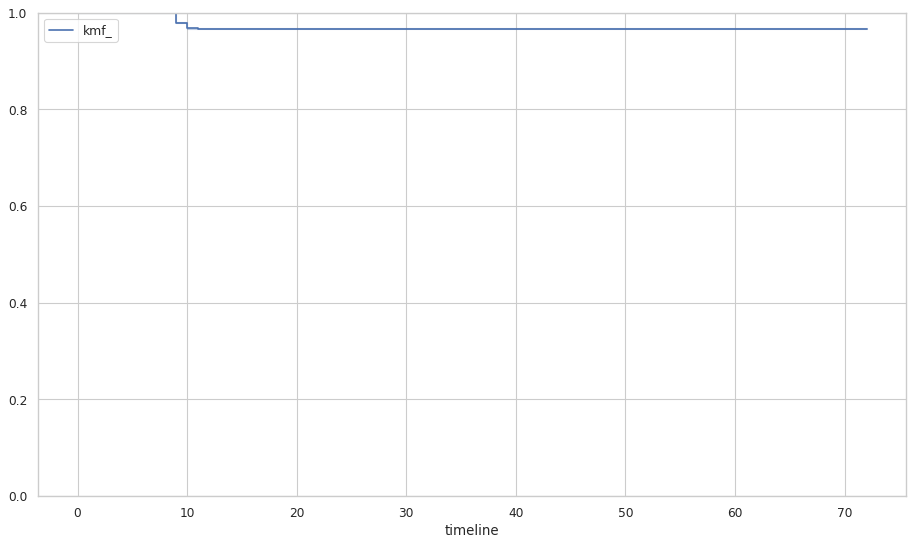

In [8]:
country_name, first_date, init_add = 'Germany', pd.to_datetime('2020-03-09'), 0.0
germany_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
germany_mortality_analysis.fit()
print(germany_mortality_analysis.death_rate())
germany_mortality_analysis.plot()

In [9]:
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,95950,26469,1452,4636,325,133
2020-04-06,98945,36081,1578,2995,9612,126
2020-04-07,103036,38287,1814,4091,2206,236
2020-04-08,108193,43656,2070,5157,5369,256
2020-04-09,112638,52407,2312,4445,8751,242


In [10]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,3683.0,2312,1371.0,3408.0,162.0,21,8521.0


In [20]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,3571.0,2070,1501.0,107.0,14,3752.0


(2.6, 2.33, 2.91, 2.57, 9.453714123258054)


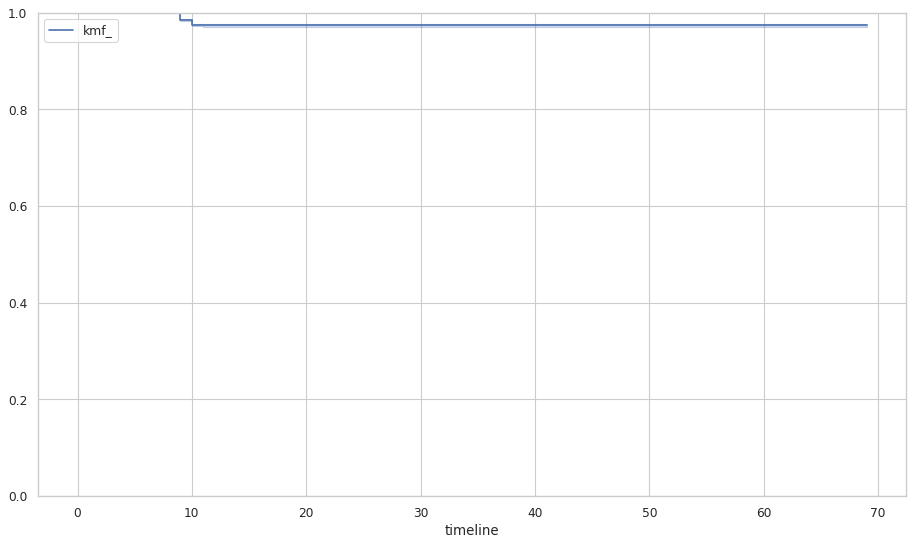

In [11]:
country_name, first_date, init_add = 'Austria', pd.to_datetime('2020-03-12'), 600
austria_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
austria_mortality_analysis.fit()
print(austria_mortality_analysis.death_rate())
austria_mortality_analysis.plot()

In [12]:
austria_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,12227,2998,204,181,0,0
2020-04-06,12494,3463,220,267,465,16
2020-04-07,12812,4046,243,318,583,23
2020-04-08,13025,4512,273,213,466,30
2020-04-09,13248,5240,295,223,728,22


In [13]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,360.0,295,65.0,296.0,14.0,21,739.0


In [25]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,367.0,273,94.0,7.0,14,235.0


(2.22, 1.94, 2.55, 1.93, 14.381445699035444)


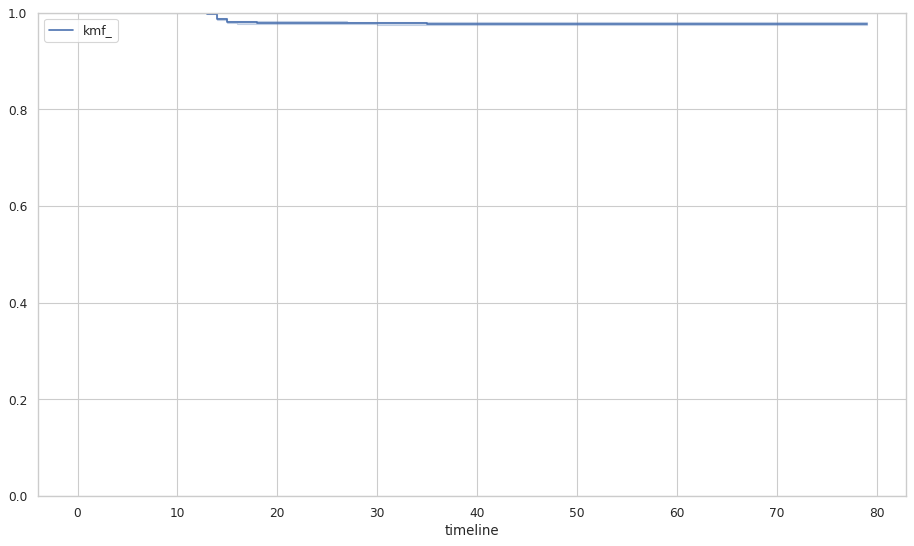

In [46]:
country_name, first_date, init_add = 'Korea, South', None, 0
south_korea_mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
south_korea_mortality_analysis.fit()
# south_korea_mortality_analysis2 = covid19.MortalityAnalysis(south_korea_name, first_date=pd.to_datetime('2020-02-20'), init_add=900)
# south_korea_mortality_analysis2.fit()
print(south_korea_mortality_analysis.death_rate())
# print(south_korea_mortality_analysis2.death_rate())
# print(south_korea_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
south_korea_mortality_analysis.plot()

In [15]:
south_korea_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,10237,6463,183,81,138,6
2020-04-06,10284,6598,186,47,135,3
2020-04-07,10331,6694,192,47,96,6
2020-04-08,10384,6776,200,53,82,8
2020-04-09,10423,6973,204,39,197,4


In [20]:
# south_korea_mortality_analysis.prepend_df

(15.06, 14.76, 15.37, 15.39, 3.760313884170126)
(3.75, 3.67, 3.83, 3.8, 3.9091199877815477)
266688


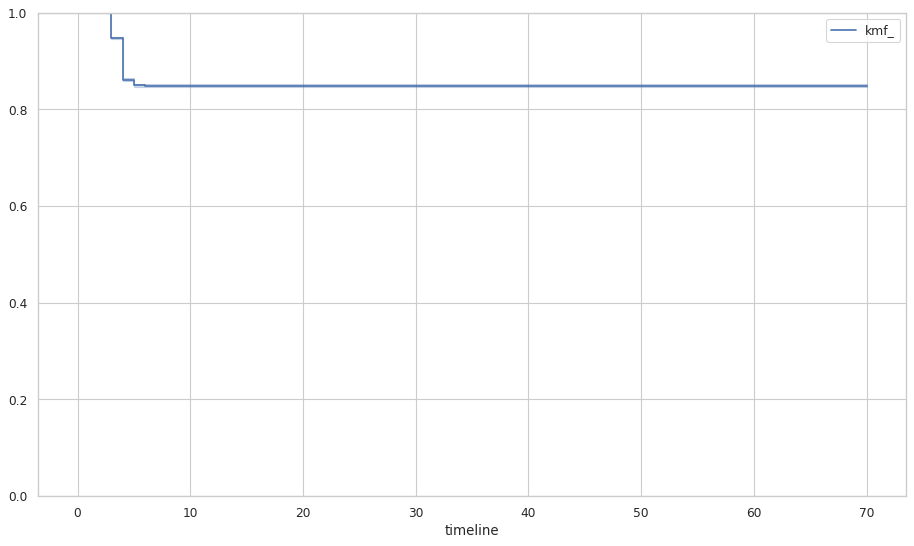

In [16]:
country_name, first_date, init_add = 'United Kingdom', pd.to_datetime('2020-03-05'), 800
uk_mortality_analysis  = covid19.MortalityAnalysis(country_name)
uk_mortality_analysis.fit()
uk_mortality_analysis2 = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add, mult=4.0)
uk_mortality_analysis2.fit()
print(uk_mortality_analysis.death_rate())
print(uk_mortality_analysis2.death_rate())
print(uk_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
uk_mortality_analysis.plot()

In [17]:
uk_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,48436,229,4943,5959,14,623
2020-04-06,52279,287,5385,3843,58,442
2020-04-07,55949,325,6171,3670,38,786
2020-04-08,61474,345,7111,5525,20,940
2020-04-09,65872,359,7993,4398,14,882


In [19]:
uk_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,10001.0,7993,2008.0,11528.0,549.0,21,28821.0


In [21]:
uk_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,17437.0,7111,10326.0,738.0,14,25814.0


In [30]:
# pd.options.mode.chained_assignment = "raise"

(4.95, 4.87, 5.02, 5.26, 5.158551344043362)
(3.3, 3.25, 3.35, 3.5, 5.138386055723748)
692830


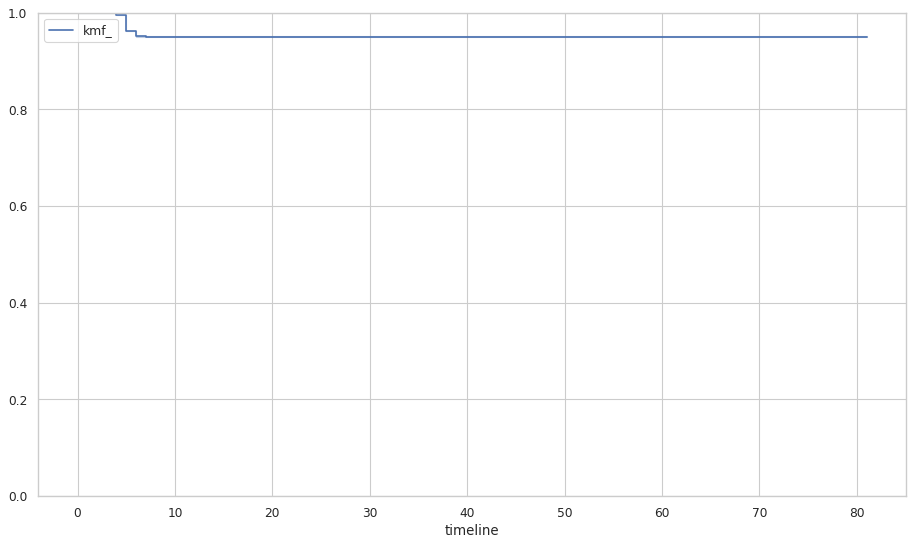

In [20]:
country_name, first_date, init_add = 'US', pd.to_datetime('2020-02-29'), 950
us_mortality_analysis  = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
us_mortality_analysis.fit()
us_mortality_analysis2 = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=450, mult=1.5)
us_mortality_analysis2.fit()
print(us_mortality_analysis.death_rate())
print(us_mortality_analysis2.death_rate())
print(us_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
us_mortality_analysis.plot()

In [21]:
us_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,337072,17448,9619,28219,2796,1212
2020-04-06,366667,19581,10783,29595,2133,1164
2020-04-07,396223,21763,12722,29556,2182,1939
2020-04-08,429052,23559,14695,32829,1796,1973
2020-04-09,461437,25410,16478,32385,1851,1783


In [22]:
us_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,22863.0,16478,6385.0,24082.0,1147.0,21,60205.0


In [24]:
us_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,35434.0,14695,20739.0,1481.0,14,51847.0


(13.56, 13.38, 13.75, 13.59, 3.252423270093119)
(3.36, 3.31, 3.41, 3.36, 3.545109562008681)
582504


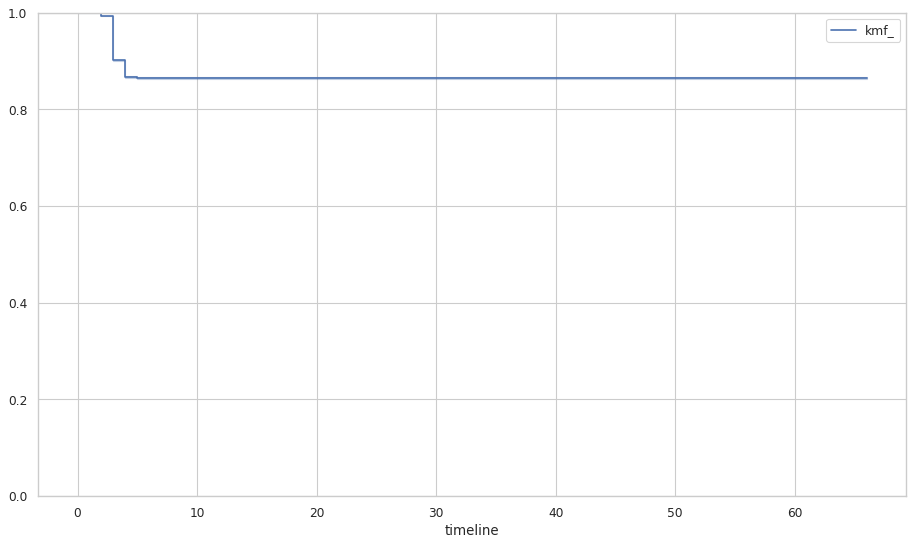

In [23]:
country_name, first_date, init_add = 'Italy', pd.to_datetime('2020-02-21'), 0
italy_mortality_analysis  = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
italy_mortality_analysis.fit()
print(italy_mortality_analysis.death_rate())
italy_mortality_analysis2  = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=2000, mult=4.0)
italy_mortality_analysis2.fit()
print(italy_mortality_analysis2.death_rate())
print(italy_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
italy_mortality_analysis.plot()

In [24]:
italy_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,128948,21815,15887,4316,819,525
2020-04-06,132547,22837,16523,3599,1022,636
2020-04-07,135586,24392,17127,3039,1555,604
2020-04-08,139422,26491,17669,3836,2099,542
2020-04-09,143626,28470,18279,4204,1979,610


In [25]:
italy_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,19572.0,18279,1293.0,14040.0,669.0,21,35101.0


In [27]:
italy_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,24268.0,17669,6599.0,471.0,14,16498.0


In [37]:
# italy_mortality_analysis2.prepend_df

(10.88, 10.72, 11.04, 10.45, 1.9467734507959071)
(3.6, 3.55, 3.66, 3.46, 2.010047824338175)
462066


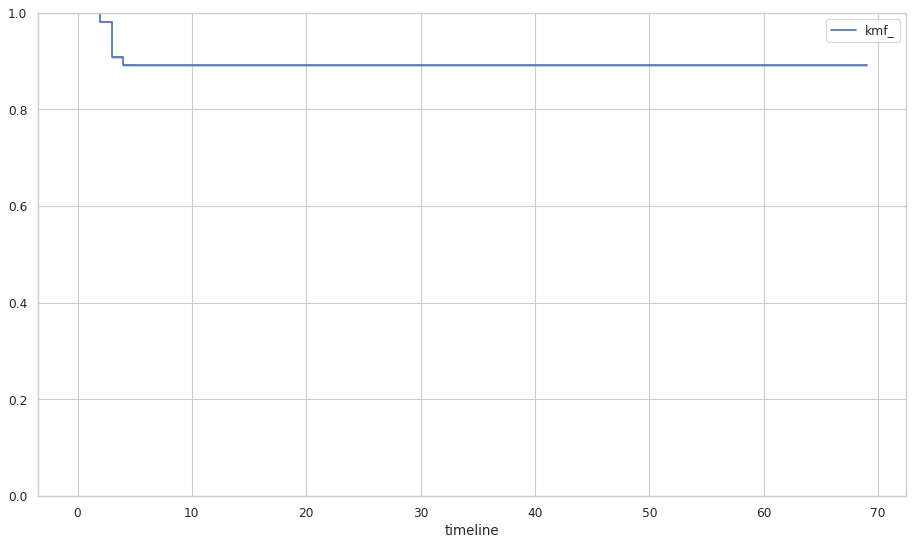

In [26]:
spain_mortality_analysis = covid19.MortalityAnalysis('Spain')
spain_mortality_analysis.fit()
spain_mortality_analysis2 = covid19.MortalityAnalysis('Spain', first_date=pd.to_datetime('2020-03-03'), init_add=800, mult=3.0)
spain_mortality_analysis2.fit()
print(spain_mortality_analysis.death_rate())
print(spain_mortality_analysis2.death_rate())
print(spain_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
spain_mortality_analysis.plot()

In [27]:
spain_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,131646,38080,12641,5478,3861,694
2020-04-06,136675,40437,13341,5029,2357,700
2020-04-07,141942,43208,14045,5267,2771,704
2020-04-08,148220,48021,14792,6278,4813,747
2020-04-09,153222,52165,15447,5002,4144,655


In [28]:
spain_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,16634.0,15447,1187.0,14740.0,702.0,21,36851.0


In [30]:
spain_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,24231.0,14792,9439.0,674.0,14,23597.0


(13.43, 13.21, 13.65, 13.99, 5.748057677657077)
(3.35, 3.3, 3.41, 3.5, 5.850799380714636)
477124


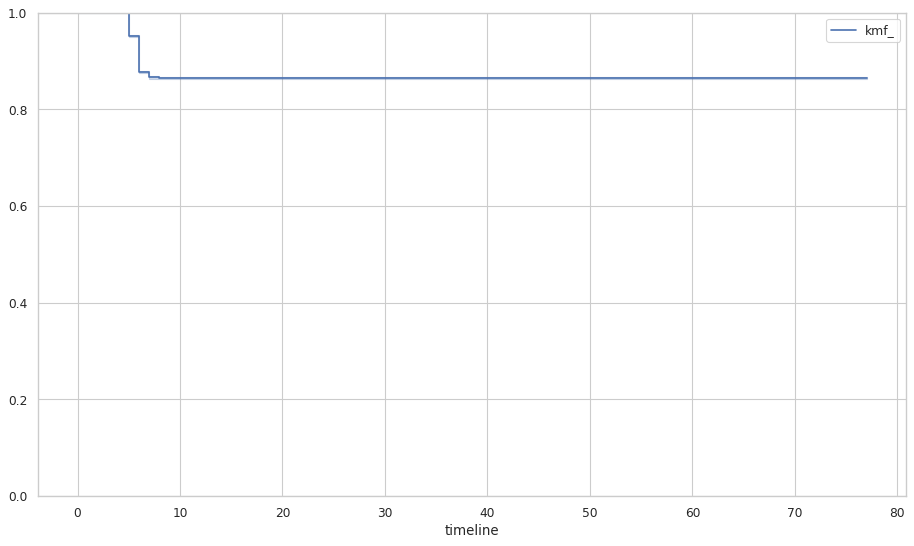

In [29]:
france_mortality_analysis = covid19.MortalityAnalysis('France')
france_mortality_analysis.fit()
france_mortality_analysis2 = covid19.MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), init_add=500, mult=4)
france_mortality_analysis2.fit()
print(france_mortality_analysis.death_rate())
print(france_mortality_analysis2.death_rate())
print(france_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
france_mortality_analysis.plot()

In [30]:
france_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,93773,16349,8093,2925,777,519
2020-04-06,98963,17428,8926,5190,1079,833
2020-04-07,110065,19523,10343,11102,2095,1417
2020-04-08,113959,21452,10887,3894,1929,544
2020-04-09,118781,23413,12228,4822,1961,1341


In [31]:
france_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,15984.0,12228,3756.0,15090.0,719.0,21,37724.0


In [33]:
france_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,21564.0,10887,10677.0,763.0,14,26693.0


In [32]:
import rpy2
print(rpy2.__version__)

3.2.6


In [33]:
import rpy2.robjects.packages as rpackages
baseR = rpackages.importr('base')
print(baseR.R_Version().rx('version.string'))

$version.string
[1] "R version 3.6.1 (2019-07-05)"




In [34]:
# from rpy2.rinterface import R_VERSION_BUILD
# print(R_VERSION_BUILD)

In [35]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:72: UserWarning: This was designed againt ggplot2 version 3.2.1 but you have 3.3.0
  'have %s' % (TARGET_VERSION, ggplot2.__version__))
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but 

In [36]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [37]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [38]:
def plot_lexis(mortality_analysis_instance):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~mortality_analysis_instance.df_lifelines_individual.observed_death
    ix_lost    = mortality_analysis_instance.df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_present], exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_present], colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_lost]   , exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_lost]   , colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

In [39]:
# plot_lexis(italy_mortality_analysis)

In [40]:
# plot_lexis(italy_mortality_analysis2)

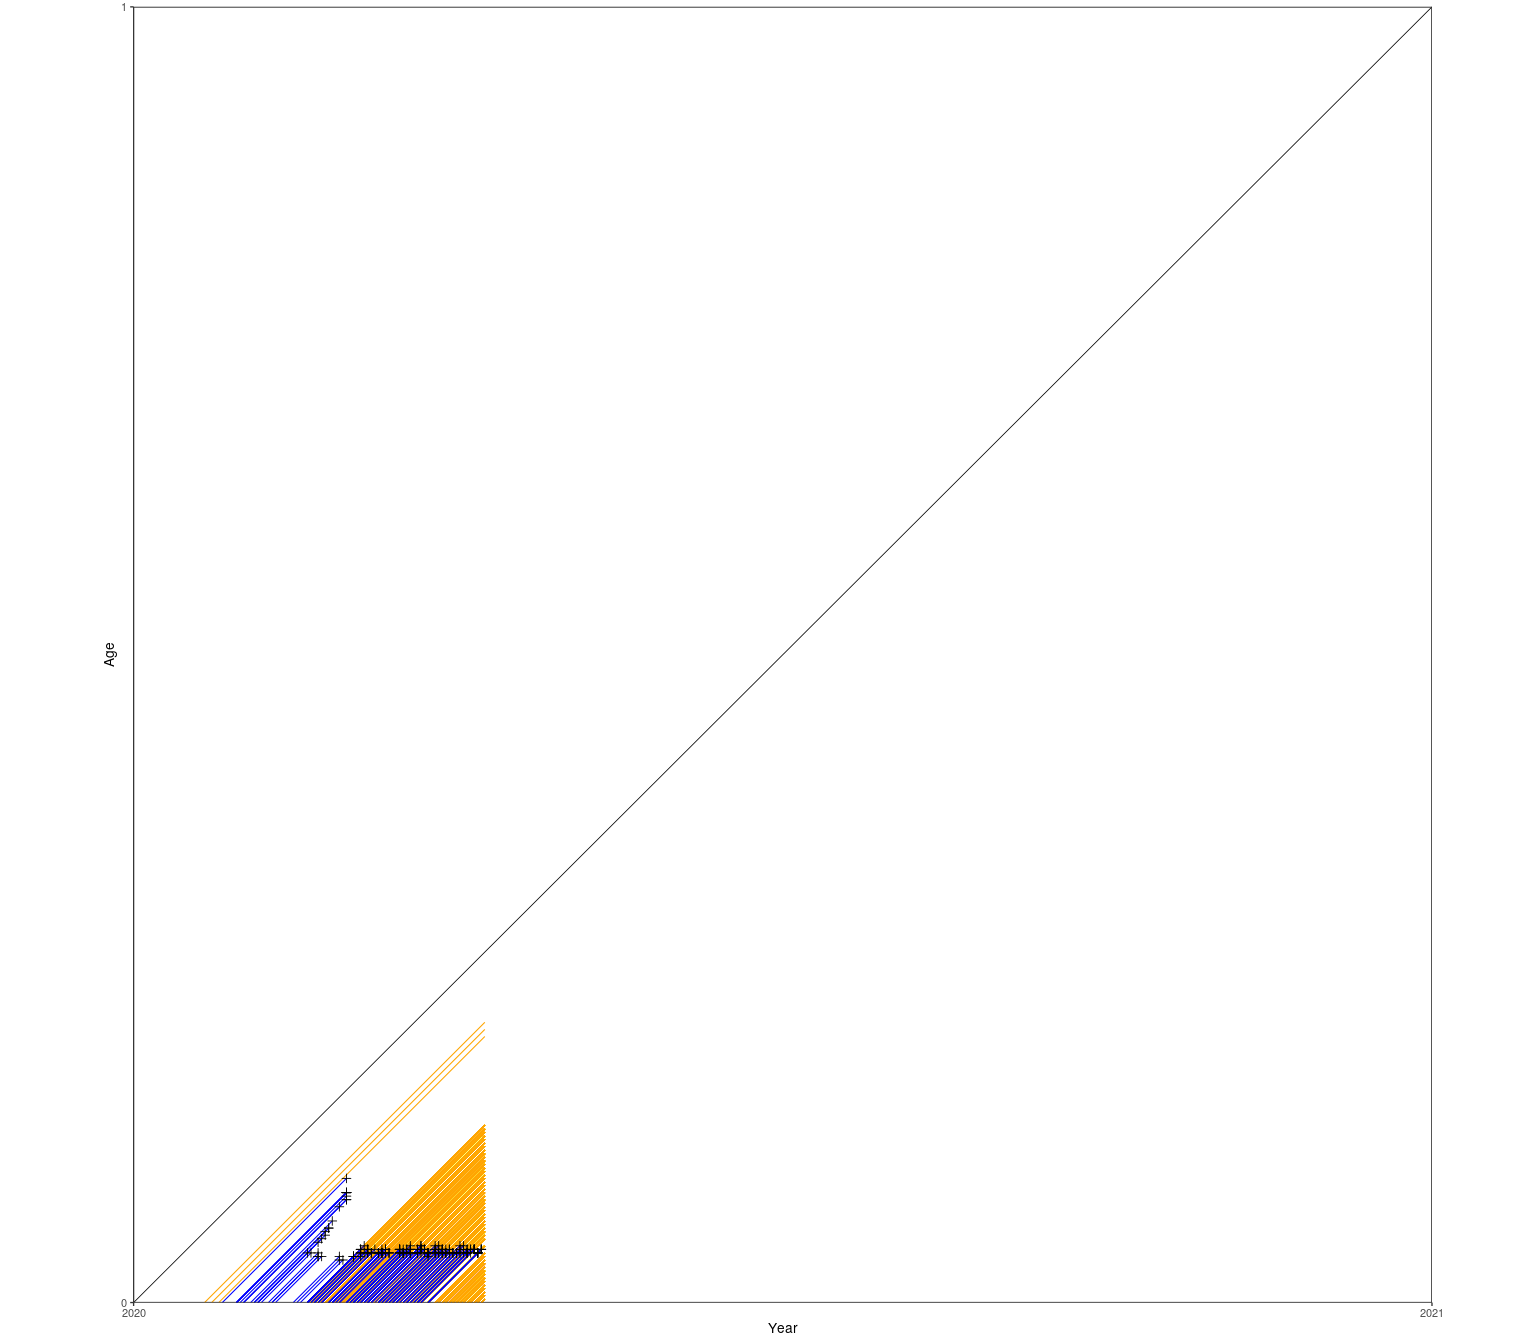

In [47]:
plot_lexis(south_korea_mortality_analysis)

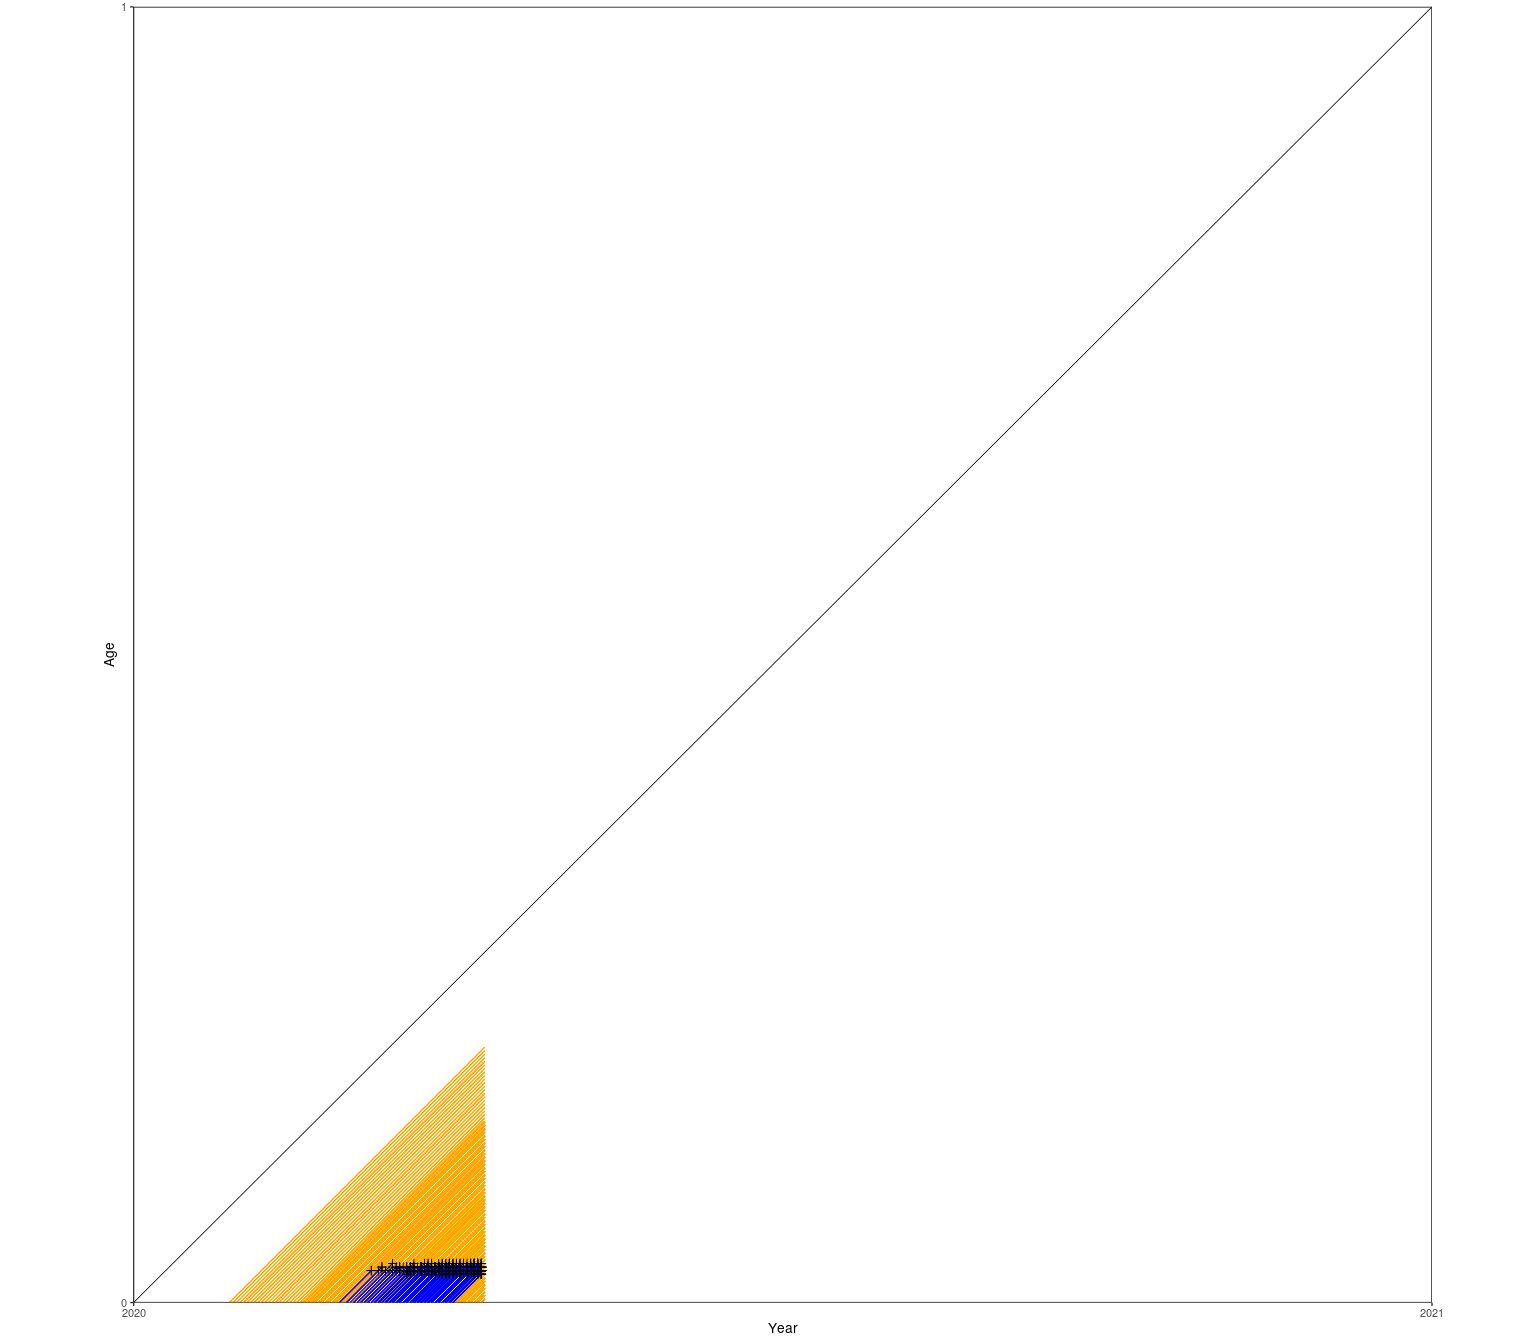

In [42]:
plot_lexis(germany_mortality_analysis)